In [1]:
import sys
sys.path.insert(0, '../archaeology')
sys.path.insert(0, '../analysis')
from math import floor, ceil, isnan
from collections import defaultdict, Counter
from pprint import pprint

import matplotlib.ticker as ticker
import matplotlib
import seaborn as sns
import pandas as pd
import numpy as np
import dask.dataframe as dd
from dask.distributed import Client
from IPython.display import display
from matplotlib import pyplot as plt

import plotly.express as px
import plotly.graph_objects as go

from db import connect, Repository, Notebook, Query
import analysis_helpers, importlib
importlib.reload(analysis_helpers)
from analysis_helpers import dask_from_query, cell_distribution
from analysis_helpers import display_counts, violinplot, describe_processed
from analysis_helpers import distribution_with_boxplot
from analysis_helpers import var, relative_var, savefig
from analysis_helpers import calculate_auto, close_fig, print_result
from analysis_helpers_general import display_barchart

%matplotlib inline

In [20]:
def display_plotlybar(df, x, y, filename, yaxis_type='log'):
    fig = px.bar(df, x, y, text=y)
    fig.update_traces(texttemplate='%{text:s}', textposition='outside')
    fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide', xaxis_tickangle=-25, yaxis_type=yaxis_type)
    fig.write_image('Trends/' + filename + '.pdf', scale=1.0)
    return fig

In [45]:
def style_bar_chart(fig, filename, xaxis_title, yaxis_title):
    fig.update_traces(texttemplate='%{y:s}', textposition='outside')
    fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide', xaxis_tickangle=-25, xaxis_title = xaxis_title, yaxis_title = yaxis_title)    
    fig.write_image('Trends/' + filename + '.pdf', scale=1.0)
    return fig    

In [4]:
with connect() as session:    
    journals = pd.read_sql_table('journal', session.connection())

In [5]:
journals.head()

,id,name,nlm_ta,iso_abbrev,issn_epub,publisher_name,publisher_loc
0,1,BMC Medical Imaging,BMC Med Imaging,BMC Med Imaging,1471-2342,BioMed Central,London
1,2,Nature,Nature,Nature,1476-4687,Nature Publishing Group UK,London
2,3,PLoS ONE,PLoS One,PLoS One,1932-6203,Public Library of Science,"San Francisco, CA USA"
3,4,PLoS Computational Biology,PLoS Comput Biol,PLoS Comput Biol,1553-7358,Public Library of Science,"San Francisco, CA USA"
4,5,eLife,eLife,Elife,2050-084X,"eLife Sciences Publications, Ltd",None


In [6]:
# Total Number of Journals
print('Journals: {}'.format(var("journals", len(journals), "{:,}")))

Journals: 373


In [7]:
with connect() as session:    
    articles = pd.read_sql_table('article', session.connection())

In [8]:
articles.head()

,id,journal_id,name,pmid,pmc,publisher_id,doi,subject,published_date,received_date,accepted_date,license_type,copyright_statement,keywords,repositories
0,1,1,Sensitivity analysis for interpretation of mac...,33588786.0,7885570,551,10.1186/s12880-021-00551-1,Software,2021-02-15,2020-10-20,2021-01-24,OpenAccess,© The Author(s) 2021,Deep learning;Neural networks;Cardiac magnetic...,https://github.com/chfc-cmi/misas;https://gith...
1,2,2,Giant lungfish genome elucidates the conquest ...,33461212.0,7875771,3198,10.1038/s41586-021-03198-8,Article,2021-01-18,2020-07-13,2021-01-06,OpenAccess,© The Author(s) 2021,Evolutionary genetics;Phylogenetics;Evolutiona...,https://github.com/schloi/MARVEL;https://githu...
2,3,3,Tracking individual honeybees among wildflower...,33571210.0,7877608,PONE-D-20-27840,10.1371/journal.pone.0239504,Research Article,2021-02-11,2020-09-04,2021-01-18,http://creativecommons.org/licenses/by/4.0/,© 2021 Ratnayake et al,,https://github.com/malikaratnayake/HyDaT_Track...
3,4,4,HippoUnit: A software tool for the automated t...,33513130.0,7875359,PCOMPBIOL-D-20-01121,10.1371/journal.pcbi.1008114,Research Article,2021-01-29,2020-06-27,2020-12-24,http://creativecommons.org/licenses/by/4.0/,© 2021 Sáray et al,,https://github.com/KaliLab/HippoUnit_demo;http...
4,5,5,In-host population dynamics of,33522489.0,7884073,61805,10.7554/eLife.61805,Research Article,2021-02-01,2020-08-05,2021-01-25,http://creativecommons.org/licenses/by/4.0/,"© 2021, Vargas et al",genomics;infectious disease;Mycobacterium tube...,https://github.com/farhat-lab/in-host-Mtbc-dyn...


In [9]:
# Total Number of Articles
print('Articles: {}'.format(var("articles", len(articles), "{:,}")))

Articles: 1,419


In [10]:
with connect() as session:    
    repositories = pd.read_sql_table('repositories', session.connection())

In [11]:
repositories.head()

,id,article_id,domain,repository,hash_dir1,hash_dir2,commit,notebooks_count,setups_count,requirements_count,notebooks,setups,requirements,processed,pipfiles_count,pipfile_locks_count,pipfiles,pipfile_locks
0,1,1,github.com,chfc-cmi/misas,fb,72c1f535128c3590fbc4947125801710adfc1e,a67e0dbc7c7dbb078f7624fc790564bb6d929b71,8,1,0,07_myops.ipynb;06_pneumothorax.ipynb;index.ipy...,setup.py,,8329,0,0,,
1,2,1,github.com,minimaxir/optillusion-animation,10,7e04a9d586713ecaddfb2e4c31f9adc1c6571c,7cf74ea556490d0eaa18916797b9d8e72411ddf4,0,0,0,,,,8329,0,0,,
2,3,2,github.com,schloi/MARVEL,c3,83cf4529160791c97340ab4d5ea091501c3451,e3f3cae82cec91ee0040889c6b5d283e50254b51,0,0,0,,,,141,0,0,,
3,4,2,github.com,Dfam-consortium/TETools,1e,2a547efd4f85c58613363150af52abbf9a6d94,2254345f9eb9d52a87d51c944a37341132600763,0,0,0,,,,8329,0,0,,
4,5,2,github.com,daler/gffutils,a4,ed69f43d0fb4b530f5563df071fc89373d945a,4b5b28e610a435af359ab1c31271deea1bae4c47,0,1,1,,setup.py,requirements.txt,8329,0,0,,


In [12]:
# Total Number of Repositories
print('Repositories: {}'.format(var("repositories", len(repositories), "{:,}")))

Repositories: 2,177


In [13]:
with connect() as session:
    query = (
        "SELECT j.name as journal_name, j.nlm_ta, j.iso_abbrev "
        "from journal j, article a where a.journal_id=j.id"
    )
    df = pd.read_sql(query, session.connection())
    df['journal_abbrev'] = np.where(df['nlm_ta']== '', df['iso_abbrev'], df['nlm_ta'])
    df['journal_abbrev'] = np.where(df['journal_abbrev']== '', df['journal_name'], df['journal_abbrev'])
    articles_per_journal = df['journal_abbrev'].value_counts()
    

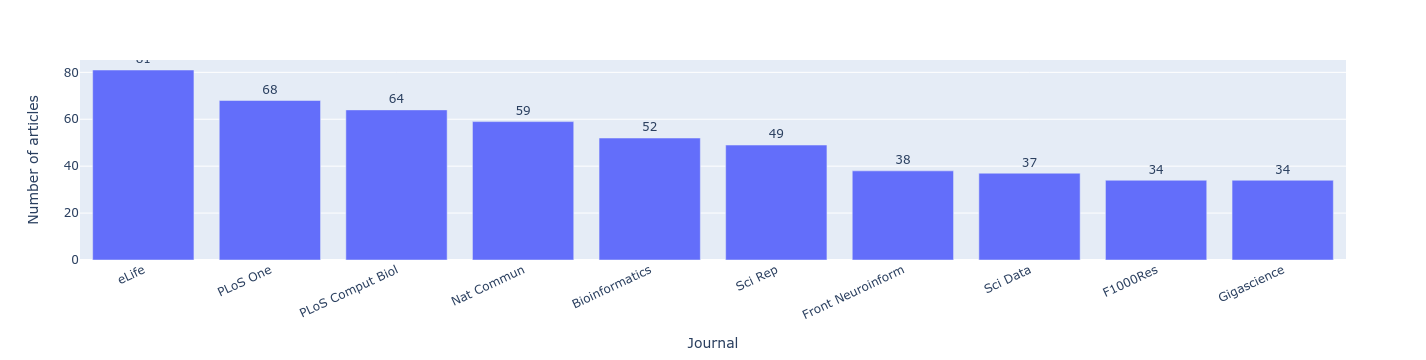

In [21]:
# Articles per Journal
articles_per_journal.columns = ['Journal', 'Number of articles']
articles_per_journal_df = pd.DataFrame({'Journal':articles_per_journal.index, 'Number of articles':articles_per_journal.values})
display_plotlybar(articles_per_journal_df.head(10), 'Journal', 'Number of articles', 'articles_per_journal', yaxis_type='linear')

In [22]:
with connect() as session:
    query = (
        "SELECT j.name as journal_name, j.nlm_ta, j.iso_abbrev, r.notebooks_count "
        "from journal j, article a, repositories r where a.journal_id=j.id and a.id=r.article_id"
    )
    df = pd.read_sql(query, session.connection())    
    df['journal_abbrev'] = np.where(df['nlm_ta']== '', df['iso_abbrev'], df['nlm_ta'])
    df['journal_abbrev'] = np.where(df['journal_abbrev']== '', df['journal_name'], df['journal_abbrev'])
    #repositories_per_journal_df = df['journal_abbrev'].value_counts()    

In [23]:
repositories_per_journal_df = df['journal_abbrev'].value_counts().reset_index()
repositories_per_journal_df.columns = ['journal_abbrev', 'repositories_count']
repositories_per_journal_df.head()

,journal_abbrev,repositories_count
0,eLife,202
1,PLoS Comput Biol,130
2,PLoS One,127
3,Nat Commun,120
4,Gigascience,102


In [24]:
repositories_with_notebooks_per_journal_df = df[df['notebooks_count'] >0]
repositories_with_notebooks_per_journal_df = repositories_with_notebooks_per_journal_df['journal_abbrev'].value_counts().reset_index()
repositories_with_notebooks_per_journal_df.columns = ['journal_abbrev', 'repositories_with_notebooks_count']
repositories_with_notebooks_per_journal_df.head()

,journal_abbrev,repositories_with_notebooks_count
0,eLife,137
1,PLoS Comput Biol,68
2,PLoS One,68
3,Nat Commun,58
4,Sci Data,48


In [25]:
min_df = df.groupby('journal_abbrev')['notebooks_count'].min().reset_index()
min_df.columns = ['journal_abbrev', 'min_notebooks_count']
max_df = df.groupby('journal_abbrev')['notebooks_count'].max().reset_index()
max_df.columns = ['journal_abbrev', 'max_notebooks_count']
jounral_min_max_nb_df = pd.merge(min_df, max_df, on="journal_abbrev", how="outer")
jounral_min_max_nb_df.head()

,journal_abbrev,min_notebooks_count,max_notebooks_count
0,ACS Energy Lett,3,3
1,Acta Crystallogr D Struct Biol,7,7
2,Adv Sci (Weinh),0,0
3,Adv Struct Chem Imaging,0,7
4,Advances in Information Retrieval,0,0


In [26]:
repo_with_without_nb_df = pd.merge(repositories_per_journal_df, repositories_with_notebooks_per_journal_df, on="journal_abbrev", how="outer")
repo_with_without_nb_df.head()

,journal_abbrev,repositories_count,repositories_with_notebooks_count
0,eLife,202,137.0
1,PLoS Comput Biol,130,68.0
2,PLoS One,127,68.0
3,Nat Commun,120,58.0
4,Gigascience,102,30.0


In [27]:
repositories_journal_df = pd.merge(repo_with_without_nb_df, jounral_min_max_nb_df, on="journal_abbrev", how="outer")
repositories_journal_df.head()

,journal_abbrev,repositories_count,repositories_with_notebooks_count,min_notebooks_count,max_notebooks_count
0,eLife,202,137.0,0,61
1,PLoS Comput Biol,130,68.0,0,115
2,PLoS One,127,68.0,0,87
3,Nat Commun,120,58.0,0,260
4,Gigascience,102,30.0,0,79


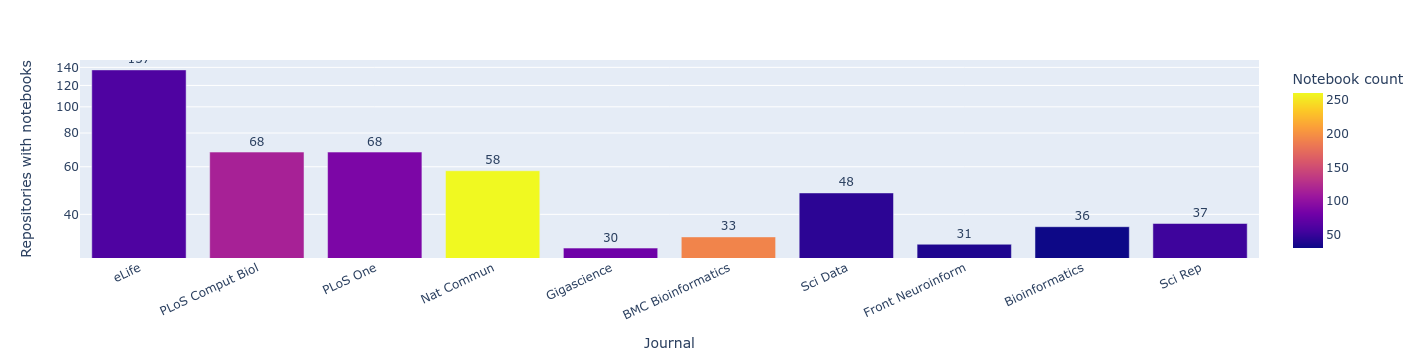

In [29]:
fig = px.bar(repositories_journal_df.head(10), x='journal_abbrev', y='repositories_with_notebooks_count', color='max_notebooks_count',
             labels=dict(journal_abbrev="Journal", repositories_count="Total repositories", repositories_with_notebooks_count="Repositories with notebooks", 
                         min_notebooks_count="Min notebook count", max_notebooks_count="Notebook count"),
        hover_data=['repositories_count', 'min_notebooks_count'], 
)
filename = 'repositories_notebooks_journals'
fig = style_bar_chart(fig, filename)
fig.show()

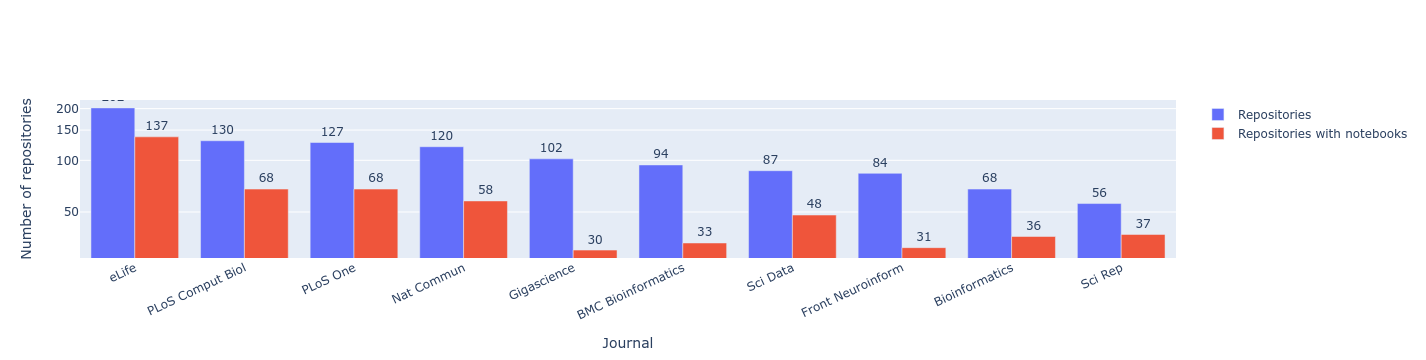

In [33]:
repositories_journal_df = repositories_journal_df.head(10)
fig = go.Figure()
fig.add_trace(go.Bar(
    x=repositories_journal_df['journal_abbrev'],
    y=repositories_journal_df['repositories_count'],
    name='Repositories',
))
fig.add_trace(go.Bar(
    x=repositories_journal_df['journal_abbrev'],
    y=repositories_journal_df['repositories_with_notebooks_count'],
    name='Repositories with notebooks',
))

filename = 'repositories_with_without_notebooks_journals'
xaxis_title = 'Journal'
yaxis_title = 'Number of repositories'
fig = style_bar_chart(fig, filename, xaxis_title, yaxis_title)
fig.show()

In [34]:
with connect() as session:
    query = (
        "SELECT j.id as journal_id, j.name as journal_name, j.nlm_ta, j.iso_abbrev, a.id as article_id, a.name as article_name, a.pmc as article_pmc, a.published_date, a.accepted_date, a.received_date, r.id as repository_id, r.notebooks_count "
        "from journal j, article a, repositories r where a.journal_id=j.id and a.id=r.article_id"
    )
    df = pd.read_sql(query, session.connection())
    df['article_date'] = np.where(df['published_date']== '', df['accepted_date'], df['published_date'])
    df['article_date'] = np.where(df['article_date']== '', df['received_date'], df['article_date'])
    df['published_year'] = pd.DatetimeIndex(df['article_date']).strftime('%Y')
    df['journal_abbrev'] = np.where(df['nlm_ta']== '', df['iso_abbrev'], df['nlm_ta'])
    df['journal_abbrev'] = np.where(df['journal_abbrev']== '', df['journal_name'], df['journal_abbrev'])


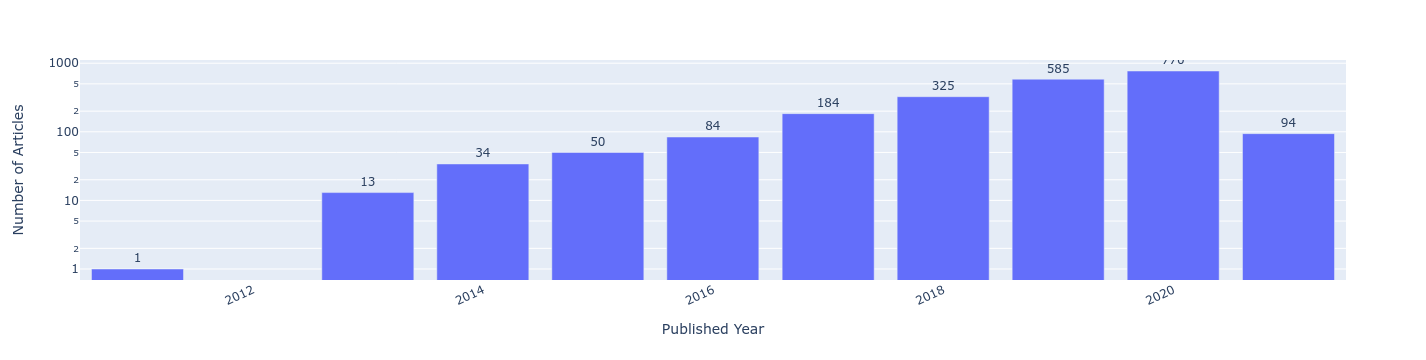

In [35]:
# Articles per year
articles_per_year = df['published_year'].value_counts()
articles_per_year.columns = ['Published Year', 'Number of Articles']
articles_per_year_df = pd.DataFrame({'Published Year':articles_per_year.index, 'Number of Articles':articles_per_year.values})
filename = 'articles_per_year'
fig = px.bar(articles_per_year_df, 'Published Year', 'Number of Articles', text='Number of Articles')
fig.update_traces(texttemplate='%{text:s}', textposition='outside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide', xaxis_tickangle=-25, xaxis_type='date', yaxis_type='log')
fig.write_image('Trends/' + filename + '.pdf', scale=1.0)
fig.show()

In [36]:
articles_repos_journal_df = df[['journal_abbrev', 'article_pmc', 'published_year', 'notebooks_count']]

articles_per_year_df = articles_repos_journal_df
articles_per_year_df = articles_per_year_df['published_year'].value_counts().reset_index()
articles_per_year_df.columns = ['published_year', 'articles_count']
articles_per_year_df.head()

,published_year,articles_count
0,2020,770
1,2019,585
2,2018,325
3,2017,184
4,2021,94


In [37]:
articles_with_notebooks_per_year_df = df[df['notebooks_count'] > 0]
articles_with_notebooks_per_year_df = articles_with_notebooks_per_year_df['published_year'].value_counts().reset_index()
articles_with_notebooks_per_year_df.columns = ['published_year', 'articles_with_notebooks_count']
articles_with_notebooks_per_year_df.head()

,published_year,articles_with_notebooks_count
0,2020,419
1,2019,287
2,2018,156
3,2017,100
4,2021,48


In [38]:
article_with_without_nb_df = pd.merge(articles_per_year_df, articles_with_notebooks_per_year_df, on="published_year", how="outer")
article_with_without_nb_df.head()

,published_year,articles_count,articles_with_notebooks_count
0,2020,770,419.0
1,2019,585,287.0
2,2018,325,156.0
3,2017,184,100.0
4,2021,94,48.0


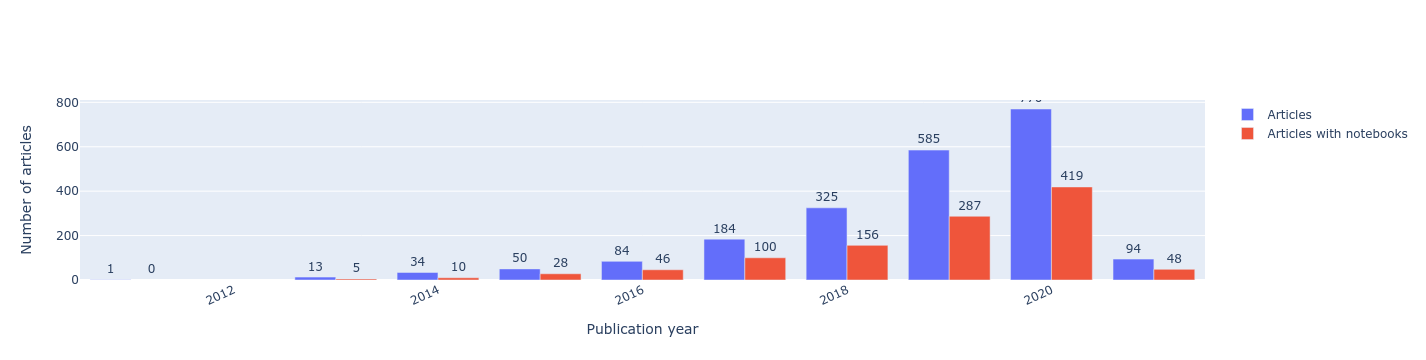

In [50]:
article_with_without_nb_df = article_with_without_nb_df.head(10)
fig = go.Figure()
fig.add_trace(go.Bar(
    x=article_with_without_nb_df['published_year'],
    y=article_with_without_nb_df['articles_count'],
    name='Articles',
))
fig.add_trace(go.Bar(
    x=article_with_without_nb_df['published_year'],
    y=article_with_without_nb_df['articles_with_notebooks_count'],
    name='Articles with notebooks',
))

filename = 'articles_with_without_notebooks_per_year'
xaxis_title = 'Publication year'
yaxis_title = 'Number of articles'
fig.update_traces(texttemplate='%{y:s}', textposition='outside')
fig.update_layout(uniformtext_minsize=4, uniformtext_mode='hide', xaxis_tickangle=-25, xaxis_type='date', xaxis_title = xaxis_title, yaxis_title = yaxis_title)    
fig.write_image('Trends/' + filename + '.pdf')
#fig = style_bar_chart(fig, filename, xaxis_title, yaxis_title, xaxis_type='date')
fig.show()

In [51]:
with connect() as session:
    query = (
        "SELECT a.id as article_id, au.id as author_id, au.orcid, a.published_date, a.name as article_name, au.name as name, au.given_names as given_names, a.accepted_date, a.received_date "
        "from article a, author au where au.article_id=a.id"
    )
    df = pd.read_sql(query, session.connection())
    df['article_date'] = np.where(df['published_date']== '', df['accepted_date'], df['published_date'])
    df['article_date'] = np.where(df['article_date']== '', df['received_date'], df['article_date'])
    df['published_year'] = pd.DatetimeIndex(df['article_date']).strftime('%Y')
    df['author_full_name'] = df['name'] + ' ' + df['given_names']

In [52]:
authors_with_orcid_df = df.groupby(['published_year'])['orcid'].size().sort_values(ascending=False)
authors_with_orcid_df.columns = ['Published Year', 'Number of Authors with ORCID']
authors_with_orcid_df.head()

published_year
2020    3545
2019    2776
2017    1706
2018    1701
2016     710
Name: orcid, dtype: int64

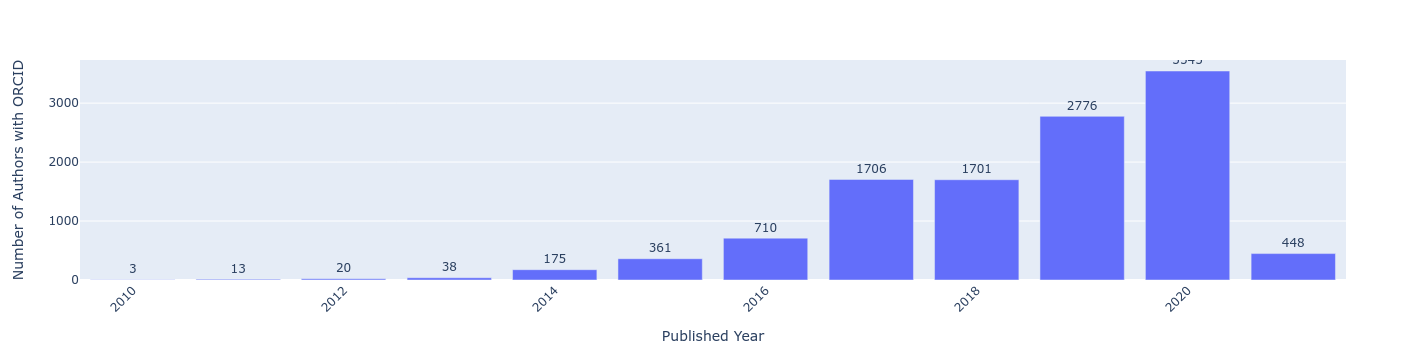

In [53]:
newdf = pd.DataFrame({'Published Year':authors_with_orcid_df.index, 'Number of Authors with ORCID':authors_with_orcid_df.values})
newdf.head()

fig = px.bar(newdf, x='Published Year', y='Number of Authors with ORCID', text='Number of Authors with ORCID')
fig.update_traces(texttemplate='%{text:.s}', textposition='outside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide', xaxis_type = 'date', xaxis_tickangle=-45)
fig.show()
fig.write_image("Trends/timeline_authors_with_orcid.pdf")

In [54]:
newdf.head()

,Published Year,Number of Authors with ORCID
0,2020,3545
1,2019,2776
2,2017,1706
3,2018,1701
4,2016,710


In [55]:
notebook_trend_df = pd.merge(articles_with_notebooks_per_year_df, authors_with_orcid_df, on="published_year", how="outer")
notebook_trend_df.dropna(inplace=True)
notebook_trend_df.head(10)

,published_year,articles_with_notebooks_count,orcid
0,2020,419.0,3545
1,2019,287.0,2776
2,2018,156.0,1701
3,2017,100.0,1706
4,2021,48.0,448
5,2016,46.0,710
6,2015,28.0,361
7,2014,10.0,175
8,2013,5.0,38


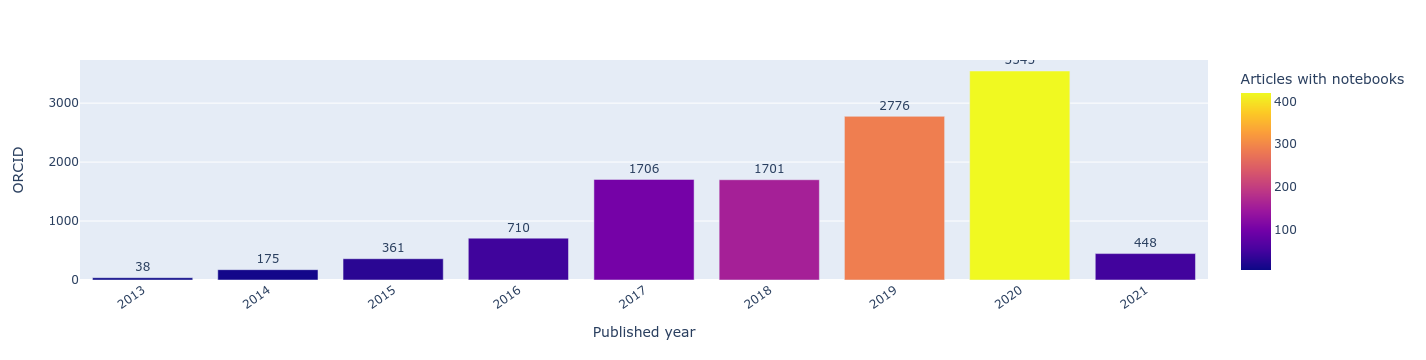

In [57]:
fig = px.bar(notebook_trend_df, x='published_year', y='orcid', color='articles_with_notebooks_count',
            labels=dict(published_year="Published year", orcid="ORCID", articles_with_notebooks_count="Articles with notebooks")
            )
fig.update_traces(texttemplate='%{y:.s}', textposition='outside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide', xaxis_type = 'date', xaxis_tickangle=-35)
fig.show()
fig.write_image("Trends/timeline_articles_authors_with_orcid.pdf")

In [58]:
with connect() as session:
    query = (
        "select n.id,n.repository_id, n.name, n.language, n.language_version, n.nbformat, n.kernel, rd.created_at "
        "from notebooks n, repository_data rd where n.repository_id=rd.repository_id"
    )
    df = pd.read_sql(query, session.connection())
    df['published_year'] = pd.DatetimeIndex(df['created_at']).strftime('%Y')


In [59]:
notebook_language_year_df = df[['language','published_year']].value_counts().reset_index().sort_index()
notebook_language_year_df.columns = ['language','published_year', 'language_count']

In [60]:
notebook_language_year_df = notebook_language_year_df[notebook_language_year_df['language_count'] > 7]
notebook_language_year_df['language'] = notebook_language_year_df['language'].str.capitalize()
notebook_language_year_df.head(80)

,language,published_year,language_count
0,Python,2019,1832
1,Python,2018,1336
2,Python,2017,1120
3,Python,2020,1047
4,Python,2016,962
5,Python,2014,850
6,Python,2015,591
7,Python,2013,253
8,R,2019,207
9,Unknown,2013,160


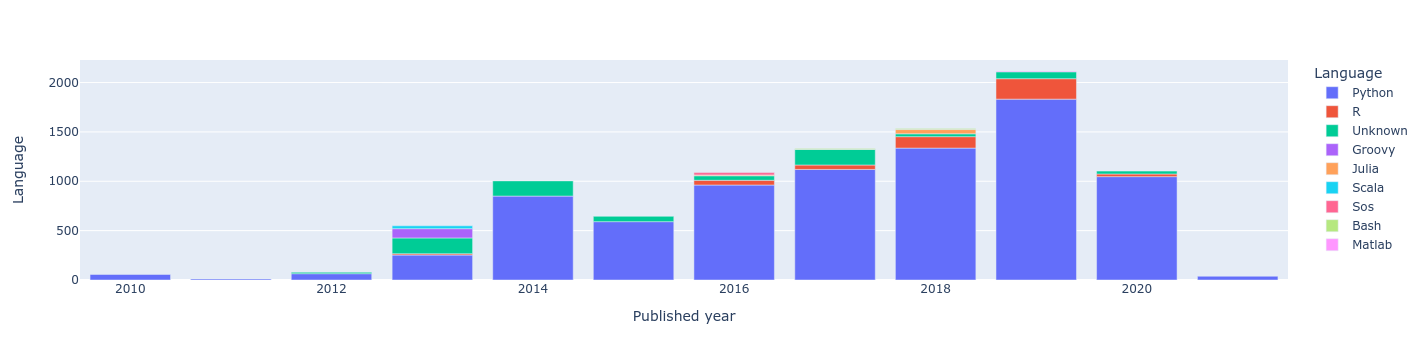

In [65]:
fig = px.bar(notebook_language_year_df, x='published_year', y='language_count', color='language',
            labels=dict(published_year="Published year", language_count="Language", language="Language")
            )
#fig.update_traces(texttemplate='%{y:.s}', textposition='outside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide', xaxis_type = 'date')
fig.show()
fig.write_image("Trends/timeline_notebook_language_year.pdf")

In [68]:
with connect() as session:
    query = (
        "select language "
        "from notebooks"
    )
    df = pd.read_sql(query, session.connection())

In [69]:
notebook_language_df = df['language'].value_counts().reset_index()
notebook_language_df.columns = ['Language','Number of notebooks']
notebook_language_df['Language'] = notebook_language_df['Language'].str.capitalize()
notebook_language_df.head()

,Language,Number of notebooks
0,Python,8160
1,Unknown,720
2,R,461
3,Groovy,95
4,Julia,59


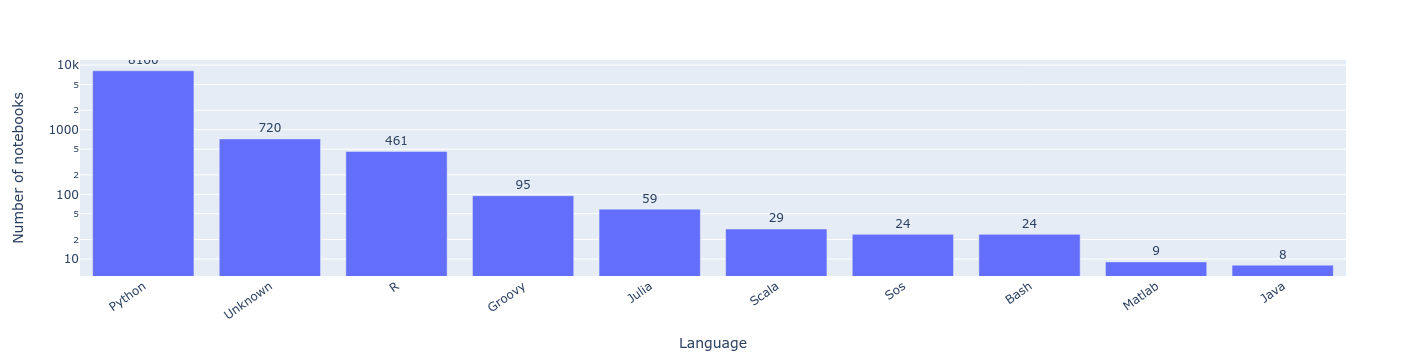

In [71]:
fig = px.bar(notebook_language_df.head(10), x='Language', y='Number of notebooks')
fig.update_traces(texttemplate='%{y:.s}', textposition='outside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide', yaxis_type = 'log', xaxis_tickangle=-35)
fig.show()
fig.write_image("Trends/top_notebook_langauge.pdf")

In [72]:
with connect() as session:
    notebooks = pd.read_sql_table("notebooks", session.connection())


In [73]:
notebooks.loc[:,"minor_version"] = notebooks["language_version"].str[:3]
notebooks.loc[:,"major_version"] = notebooks["language_version"].str[:1]
python_notebooks = notebooks[notebooks.language == "python"]
# Removing inconsistencies
python_notebooks = python_notebooks[
    ~python_notebooks["language_version"].isin({"3", "1", "ES2015"})
]
python_notebooks.head()

,id,repository_id,name,nbformat,kernel,language,language_version,max_execution_count,total_cells,code_cells,...,processed,skip,sha1_source,homework_count,assignment_count,course_count,exercise_count,lesson_count,minor_version,major_version
8,9,7,jupyter/Lungfish_MARVEL_benchmark.ipynb,4.4,python3,python,3.6.6,44,4,4,...,131104,0,9daa0293bd946bc23fb60c03feaee447138fead4,0,0,0,0,0,3.6,3
9,10,7,jupyter/plotRegion.ipynb,4.4,python3,python,3.6.6,36,9,9,...,131104,0,36b3a8f5b325e4328457d176df3b7f49cee0f4f6,0,0,0,0,0,3.6,3
10,11,7,jupyter/calculateReadCoverage.ipynb,4.4,python3,python,3.6.6,39,9,9,...,131104,0,206e926f9c4eae1adee81cc0bb8b6235e8683d79,0,0,0,0,0,3.6,3
11,12,7,jupyter/plotScaffoldCoverage.ipynb,4.4,python3,python,3.6.6,66,10,10,...,131104,0,ee43ede71931bedb554e2e1ac1b6252455e3df9e,0,0,0,0,0,3.6,3
12,13,7,jupyter/kmer Lungfish.ipynb,4.4,python3,python,3.7.6,38,13,13,...,131104,0,24d4bbed6774fd1e25270806258e0caba8f4a907,0,0,0,0,0,3.7,3


In [74]:
python_major_version_df = python_notebooks["major_version"].value_counts().reset_index()
python_major_version_df.head()

,index,major_version
0,3,6028
1,2,1802
2,u,329


In [75]:
python_minor_version_df = python_notebooks["minor_version"].value_counts().reset_index().sort_values(by=['index'])
python_minor_version_df.head()

,index,minor_version
2,2.7,1802
6,3.4,174
3,3.5,930
0,3.6,2471
1,3.7,2031


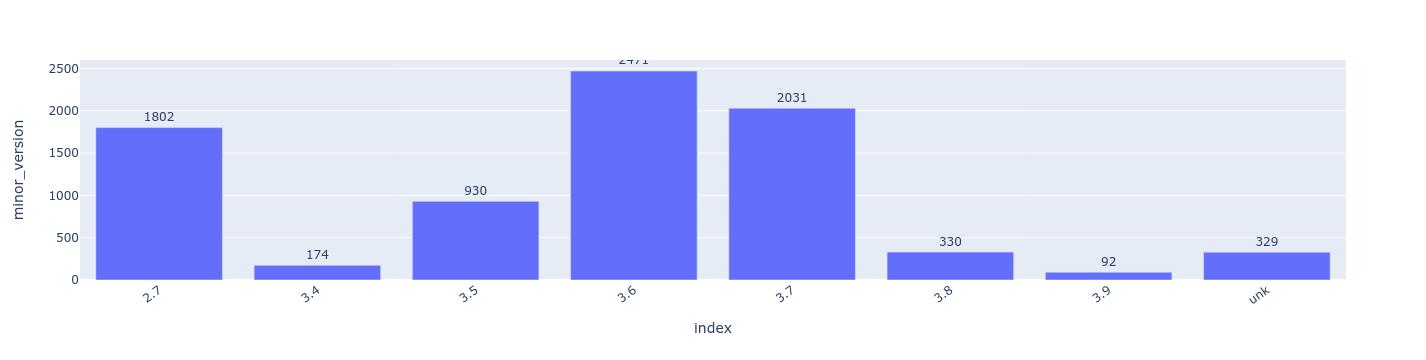

In [76]:
fig = px.bar(python_minor_version_df, x='index', y='minor_version')
fig.update_traces(texttemplate='%{y:.s}', textposition='outside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide', xaxis_tickangle=-35)
fig.show()
fig.write_image("Trends/python_minor_version.pdf")

In [77]:
with connect() as session:
    query = (
        "select n.id,n.repository_id, n.name, n.language, n.language_version, n.nbformat, n.kernel, rd.created_at, rd.updated_at, rd.pushed_at "
        "from notebooks n, repository_data rd where n.repository_id=rd.repository_id"
    )
    notebooks = pd.read_sql(query, session.connection())    
notebooks.head()

,id,repository_id,name,language,language_version,nbformat,kernel,created_at,updated_at,pushed_at
0,1,1,07_myops.ipynb,unknown,unknown,4.4,misas,2020-05-26 12:01:36,2021-01-14 08:36:46,2021-01-14 08:36:43
1,2,1,06_pneumothorax.ipynb,unknown,unknown,4.4,python3,2020-05-26 12:01:36,2021-01-14 08:36:46,2021-01-14 08:36:43
2,3,1,index.ipynb,unknown,unknown,4.4,misas,2020-05-26 12:01:36,2021-01-14 08:36:46,2021-01-14 08:36:43
3,4,1,04_mr_artifacts.ipynb,unknown,unknown,4.4,misas,2020-05-26 12:01:36,2021-01-14 08:36:46,2021-01-14 08:36:43
4,5,1,03_transversals.ipynb,unknown,unknown,4.4,misas,2020-05-26 12:01:36,2021-01-14 08:36:46,2021-01-14 08:36:43


In [78]:
notebooks.loc[:,"minor_version"] = notebooks["language_version"].str[:3]
notebooks.loc[:,"major_version"] = notebooks["language_version"].str[:1]
python_notebooks = notebooks[notebooks.language == "python"]
# Removing inconsistencies
python_notebooks = python_notebooks[
    ~python_notebooks["language_version"].isin({"3", "1", "ES2015"})
]
python_notebooks.head()

,id,repository_id,name,language,language_version,nbformat,kernel,created_at,updated_at,pushed_at,minor_version,major_version
8,9,7,jupyter/Lungfish_MARVEL_benchmark.ipynb,python,3.6.6,4.4,python3,2020-11-25 21:22:23,2021-02-05 07:30:32,2021-01-22 08:45:27,3.6,3
9,10,7,jupyter/plotRegion.ipynb,python,3.6.6,4.4,python3,2020-11-25 21:22:23,2021-02-05 07:30:32,2021-01-22 08:45:27,3.6,3
10,11,7,jupyter/calculateReadCoverage.ipynb,python,3.6.6,4.4,python3,2020-11-25 21:22:23,2021-02-05 07:30:32,2021-01-22 08:45:27,3.6,3
11,12,7,jupyter/plotScaffoldCoverage.ipynb,python,3.6.6,4.4,python3,2020-11-25 21:22:23,2021-02-05 07:30:32,2021-01-22 08:45:27,3.6,3
12,13,7,jupyter/kmer Lungfish.ipynb,python,3.7.6,4.4,python3,2020-11-25 21:22:23,2021-02-05 07:30:32,2021-01-22 08:45:27,3.7,3


In [90]:
python_notebooks['created_year'] = pd.DatetimeIndex(python_notebooks['created_at']).strftime('%Y')

In [91]:
python_minor_version_df = python_notebooks[['created_year', 'minor_version',]].value_counts().reset_index().sort_values(by=['minor_version'])
python_minor_version_df.columns = ['Year of creation', 'Minor version','Number of notebooks']

In [92]:
python_minor_version_df = python_minor_version_df[python_minor_version_df['Year of creation'] > '2013']

In [93]:
python_major_version_df = python_notebooks[['created_year', 'major_version']].value_counts().reset_index()
python_major_version_df.columns = ['Year of creation', 'Major version','Number of notebooks']
python_major_version_df.head()

,Year of creation,Major version,Number of notebooks
0,2019,3,1699
1,2018,3,1149
2,2020,3,982
3,2017,3,818
4,2016,3,600


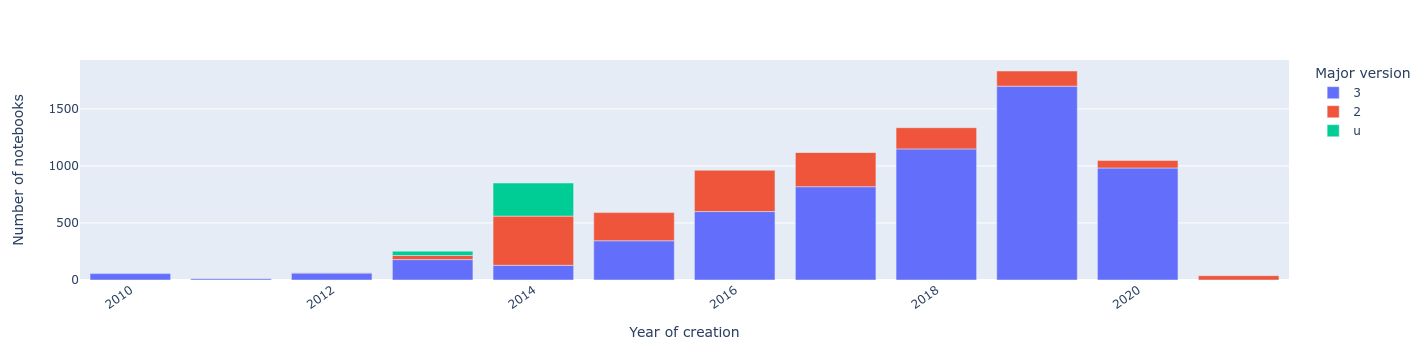

In [95]:
fig = px.bar(python_major_version_df, x='Year of creation', y='Number of notebooks', color='Major version')
#fig.update_traces(texttemplate='%{y:.s}', textposition='outside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide', xaxis_tickangle=-35, xaxis_type='date')
fig.show()
fig.write_image("Trends/timeline_python_major_version_by_repo_creation.pdf")

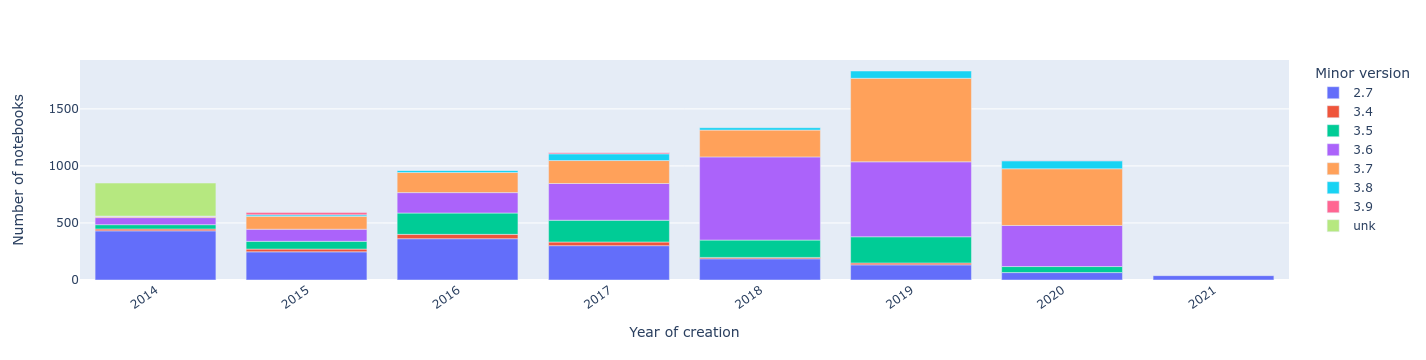

In [97]:
fig = px.bar(python_minor_version_df, x='Year of creation', y='Number of notebooks', color='Minor version')
#fig.update_traces(texttemplate='%{y:.s}', textposition='outside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide', xaxis_tickangle=-35, xaxis_type='date')
fig.show()
fig.write_image("Trends/timeline_python_minor_version_by_repo_creation.pdf")

In [98]:
python_notebooks['updated_year'] = pd.DatetimeIndex(python_notebooks['updated_at']).strftime('%Y')

In [99]:
python_minor_version_df = python_notebooks[['updated_year', 'minor_version']].value_counts().reset_index().sort_values(by=['minor_version'])
python_minor_version_df.columns = ['Year of last update', 'Minor version','Number of notebooks']
python_minor_version_df = python_minor_version_df[python_minor_version_df['Year of last update'] > '2015']

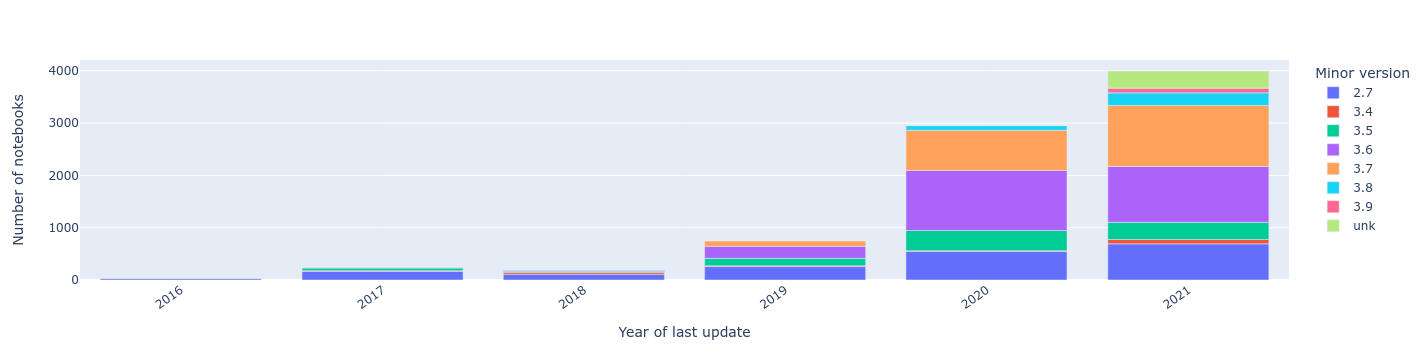

In [100]:
fig = px.bar(python_minor_version_df, x='Year of last update', y='Number of notebooks', color='Minor version')
#fig.update_traces(texttemplate='%{y:.s}', textposition='outside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide', xaxis_tickangle=-35, xaxis_type='date')
fig.show()
fig.write_image("Trends/timeline_python_minor_version_by_repo_updation.pdf")

In [101]:
with connect() as session:
    query = (
        "SELECT * "
        "from notebook_code_style"
    )
    nb_pycodestyle_errors = pd.read_sql(query, session.connection())

In [102]:
nb_pycodestyle_errors.head()

,id,cell_index,err_code,err_code_desc,notebook_id,repository_id
0,1,1,F404,from __future__ imports must occur at the begi...,18,12
1,2,1,E402,module level import not at top of file,18,12
2,3,1,E402,module level import not at top of file,18,12
3,4,1,E402,module level import not at top of file,18,12
4,5,1,F403,'from json2html import *' used; unable to dete...,18,12


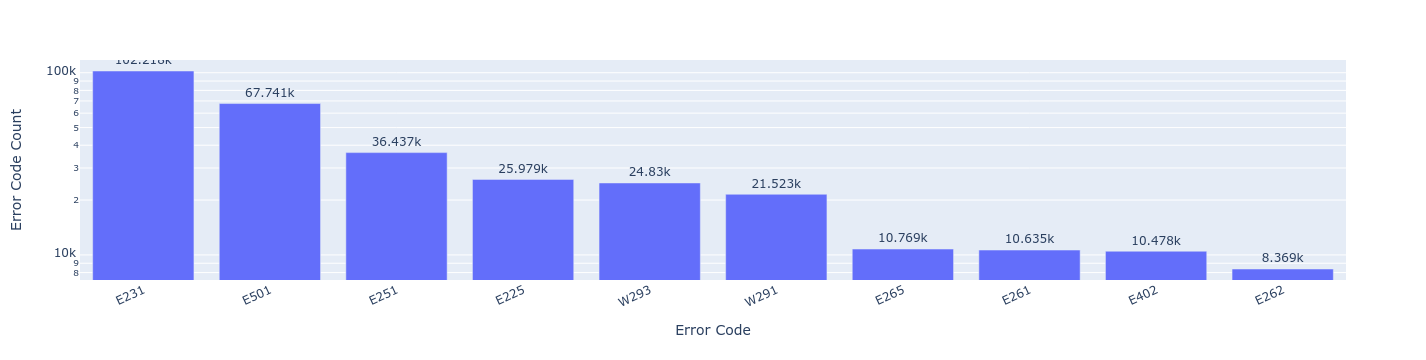

In [103]:
df = nb_pycodestyle_errors.groupby(['err_code'])['err_code_desc'].size().sort_values(ascending=False)
df.columns = ['Error Code', 'Error Code Count']
nb_pycodestyle_errors_df = pd.DataFrame({'Error Code':df.index, 'Error Code Count':df.values})
display_plotlybar(nb_pycodestyle_errors_df.head(10), 'Error Code', 'Error Code Count', 'nb_pycodestyle_errors')

In [104]:
df = nb_pycodestyle_errors.groupby(['err_code'])['err_code_desc'].size().sort_values(ascending=False)
df.columns = ['err_code', 'err_code_desc']
nb_pycodestyle_errors_df = pd.DataFrame({'err_code':df.index, 'err_code_desc':df.values})
nb_pycodestyle_errors_df.head(30)

,err_code,err_code_desc
0,E231,102218
1,E501,67741
2,E251,36437
3,E225,25979
4,W293,24830
5,W291,21523
6,E265,10769
7,E261,10635
8,E402,10478
9,E262,8369


In [105]:
nb_pycodestyle_errors_df.loc[nb_pycodestyle_errors_df['err_code'] == 'W601']

,err_code,err_code_desc
67,W601,7
